In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
modver = '202007I'
datespan = '20160101-20160430'
start_date=dt.datetime(2016,1,1)
end_date=dt.datetime(2016,4,30)
matchpath='/home/sallen/202007/202007I/'

flen=1
namfmt='long'
filemap={'dissolved_oxygen':'carp_T',}
fdict={'carp_T':24,'grid_T':24}

df1=et.loadDFO(datelims=(start_date,end_date))
print(df1.keys())

Index(['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Pressure', 'Depth',
       'Chlorophyll_Extracted', 'Chlorophyll_Extracted_units', 'N', 'Si',
       'Silicate_units', 'AbsSal', 'ConsT', 'Oxygen_Dissolved',
       'Oxygen_Dissolved_units', 'Z', 'dtUTC'],
      dtype='object')


In [3]:
data=et.matchData(df1,filemap,fdict,start_date,end_date,namfmt,matchpath,flen,quiet=True);

In [4]:
data=data.loc[data.Oxygen_Dissolved>=0].reset_index().copy(deep=True)

In [5]:
display(Markdown('''### DFO Comparisons '''))
display(Markdown('''###   ''' + modver))
display(Markdown('''###    '''+ str(datespan)))
display(Markdown('''####   File: '''+ matchpath))

### DFO Comparisons 

###   202007I

###    20160101-20160430

####   File: /home/sallen/202007/202007I/

In [6]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [7]:
print('Fields available:')
print([el for el in data.keys()])

Fields available:
['index', 'Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Pressure', 'Depth', 'Chlorophyll_Extracted', 'Chlorophyll_Extracted_units', 'N', 'Si', 'Silicate_units', 'AbsSal', 'ConsT', 'Oxygen_Dissolved', 'Oxygen_Dissolved_units', 'Z', 'dtUTC', 'j', 'i', 'mod_dissolved_oxygen', 'k']


In [8]:
len(df1.loc[df1.Oxygen_Dissolved>=0])

298

In [9]:
# umol/kg * kg/m3 *m3/L=umol/L= oxy0*rho/1000
data['rho']=gsw.rho(data['AbsSal'],data['ConsT'],data['Pressure'])
data['Oxy_uM']=data['Oxygen_Dissolved']*data['rho']/1e3
#data['CTDOxy_uM']=data['Oxygen_Dissolved_SBE']*data['rho']/1e3

In [10]:
cm1=cmocean.cm.thermal
year=data.dtUTC[0].year
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [11]:
def byDepth(ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims):
    ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b',),lname='SJDF')
    ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c',),lname='SJGI')
    ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y',),lname='SOG')
    ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m',),lname='NSOG')
    l=ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return (ps1,ps2,ps3,ps4),l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

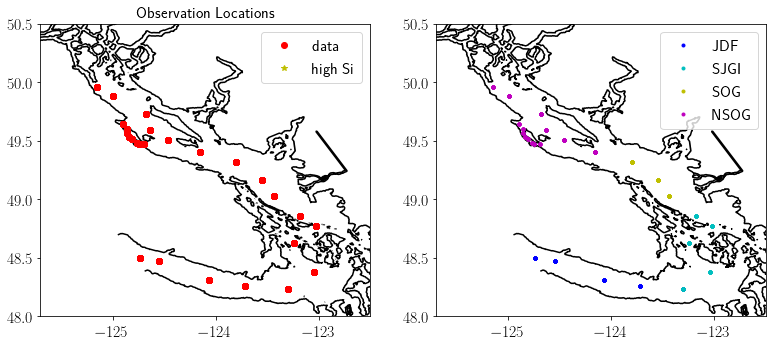

In [12]:
fig, ax = plt.subplots(1,2,figsize = (13,6))
viz_tools.set_aspect(ax[0], coords = 'map')
ax[0].plot(data['Lon'], data['Lat'], 'ro',label='data')
ax[0].plot(data.loc[data.Si>75,['Lon']],data.loc[data.Si>75,['Lat']],'*',color='y',label='high Si')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax[0], grid, coords = 'map',isobath=.1)
ax[0].set_ylim(48, 50.5)
ax[0].legend()
ax[0].set_xlim(-125.7, -122.5);
ax[0].set_title('Observation Locations');

viz_tools.set_aspect(ax[1], coords = 'map')
#ax[1].plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.3)&(data.Lat<48.6)]
ax[1].plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax[1].plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax[1].plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax[1].plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax[1], grid, coords = 'map')
ax[1].set_ylim(48, 50.5)
ax[1].legend()
ax[1].set_xlim(-125.7, -122.5);

# Also set up seasonal groupings:
iz=(data.Z<15)
JFM=data.loc[iz&(data.dtUTC<=dt.datetime(year,4,1)),:]
Apr=data.loc[iz&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1)),:]
MJJA=data.loc[iz&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1)),:]
SOND=data.loc[iz&(data.dtUTC>dt.datetime(year,9,1)),:]

In [13]:
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND,
                      'SJDF':dJDF,
                      'SJGI':dSJGI,
                      'SOG':dSOG,
                      'NSOG':dNSOG})

(-160, 160)

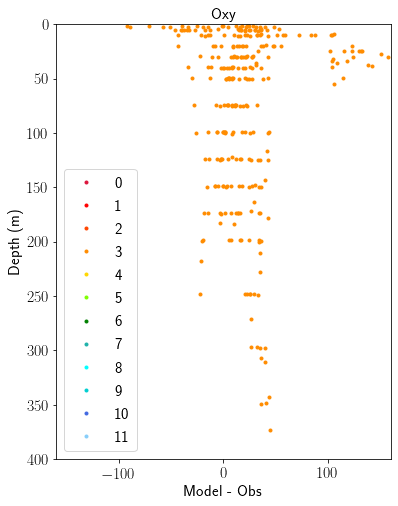

In [14]:
fig, ax = plt.subplots(1,1,figsize = (6,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'darkturquoise','royalblue','lightskyblue','blue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
start_date=dt.datetime(np.min(data['dtUTC']).year,1,1)
end_date=dt.datetime(np.max(data['dtUTC']).year+1,1,1)
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax.plot(data.loc[iii,['mod_dissolved_oxygen']].values-data.loc[iii,['Oxy_uM']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))

ax.legend(loc=3)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Model - Obs')
ax.set_xlabel('Model - Obs')
ax.set_title('Oxy')
ax.set_ylim(400,0)
ax.set_xlim(-160,160)

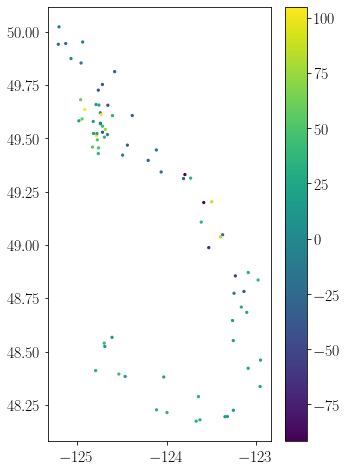

In [15]:
fig,ax=plt.subplots(1,1,figsize=(5,8))
idata=data.loc[data.Z<15]
eps=np.random.uniform(-.1,.1,size=len(idata))
eps2=np.random.uniform(-.1,.1,size=len(idata))
m=ax.scatter(idata['Lon']+eps,idata['Lat']+eps2,c=idata['mod_dissolved_oxygen']-idata['Oxy_uM'],s=5)
fig.colorbar(m,ax=ax)

Text(0.5, 1.0, 'Model')

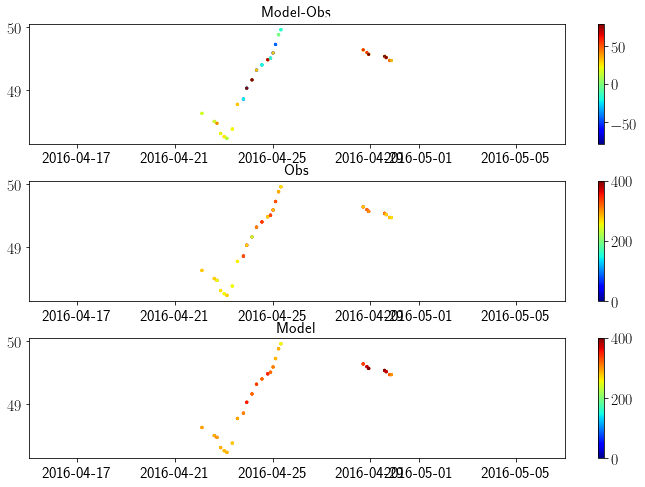

In [24]:
fig,ax=plt.subplots(3,1,figsize=(12,8))
fig.subplots_adjust(hspace=.3)
cm=plt.get_cmap('jet')
idata=data.loc[data.Z<15]
m0=ax[0].scatter(idata['dtUTC'],idata['Lat'],c=idata['mod_dissolved_oxygen']-idata['Oxy_uM'],
                 s=5,vmin=-80,vmax=80,cmap=cm)
fig.colorbar(m0,ax=ax[0])
m1=ax[1].scatter(idata['dtUTC'],idata['Lat'],c=idata['Oxy_uM'],s=5,vmin=0,vmax=400,cmap=cm)
fig.colorbar(m1,ax=ax[1])
m2=ax[2].scatter(idata['dtUTC'],idata['Lat'],c=idata['mod_dissolved_oxygen'],s=5,vmin=0,vmax=400,cmap=cm)
fig.colorbar(m2,ax=ax[2])
ax[0].set_title('Model-Obs')
ax[1].set_title('Obs')
ax[2].set_title('Model')

# Oxygen

In [17]:
obsvar='Oxy_uM'
modvar='mod_dissolved_oxygen'
statsDict={year:dict()}
statsDict[year]['Oxy']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Oxy'][isub]=dict()
    var=statsDict[year]['Oxy'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['Oxy'],level='Subset',suborder=list(statsubs.keys()))
tbl

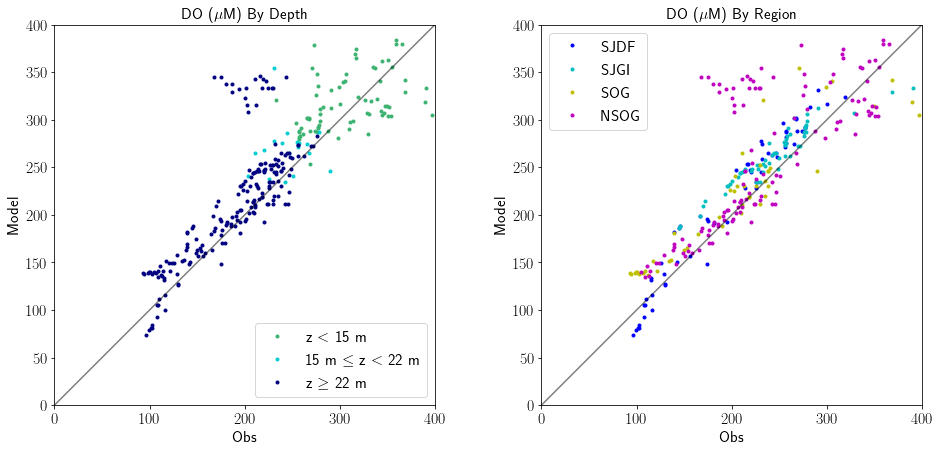

In [18]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,400))
ax[0].set_title('DO ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,400))
ax[1].set_title('DO ($\mu$M) By Region');

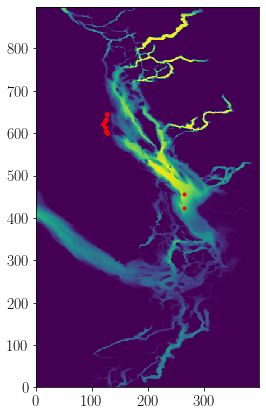

In [22]:
fig,ax=plt.subplots(1,1,figsize=(4,7))
ax.pcolormesh(bathyZ)
datahi=data.loc[data.mod_dissolved_oxygen-data.Oxy_uM>80]
ax.plot(datahi['i'],datahi['j'],'r.')

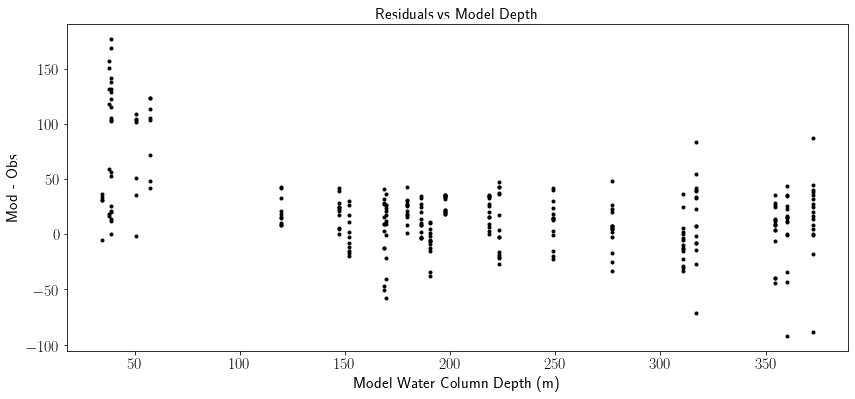

In [26]:
fig, ax = plt.subplots(1,1,figsize = (14,6))
obsvar='Oxy_uM'; modvar='mod_dissolved_oxygen'
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc') as fm:
    bathy=np.sum(fm.variables['tmask'][0,:,:,:]*fm.variables['e3t_0'][0,:,:,:],0)
data['bathy']=[bathy[j,i] for j,i in zip(data['j'],data['i'])]
ax.plot(data['bathy'],data[modvar]-data[obsvar],'k.')
ax.set_title('Residuals vs Model Depth');
ax.set_xlabel('Model Water Column Depth (m)')
ax.set_ylabel('Mod - Obs ');